In [1]:

# Pytorch Elements
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

# PyTorch TensorBoard Support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Visualization tools
import matplotlib.pyplot as plt

# Post-deep learning analysis
from sklearn.metrics import confusion_matrix

# Support libraries
import numpy as np
import itertools
import os
import random


In [2]:
# Use GPU if available
# gpu_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# gpu_device

Uploading the Data

In [3]:
batch_size_train=4
batch_size_test=8

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Resize((246,246))])

# Create datasets for training & validation, download if necessary
training_set = datasets.ImageFolder('./train', transform=transform)
test_set = datasets.ImageFolder('./test', transform=transform)


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, shuffle=True)
validation_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False)

# Class labels
classes = ('benign', 'malignant')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Test set has {} instances'.format(len(test_set)))

Training set has 1148 instances
Test set has 545 instances


Printing images batch matrix and their labels

malignant  malignant  malignant  malignant


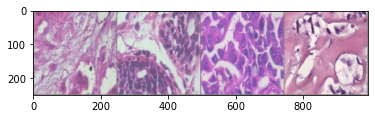

In [5]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)
print('  '.join(classes[labels[j]] for j in range(batch_size_train)))

Condtruct the vgg16 NN

In [6]:
# Manually build vgg16 network
vgg16_layers_list = [64, 64,'M',
         128, 128, 'M',
         256, 256, 256, 'M',
         512, 512, 512, 'M',
         512, 512, 512, 'M']

class Manual_vgg16(nn.Module):
    def __init__(self, num_of_channels=3, num_classes=2):
        super(Manual_vgg16, self).__init__()
        self.image_channels = num_of_channels
        self.conv_layers = self.create_conv_layers(vgg16_layers_list)
        
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
        
        
    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.image_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fully_connected_layers(x)
        return x
    
    def predict(self, x):
        # a function to predict the labels of a batch of inputs
        x = F.softmax(self.forward(x, training=False))
        return 
    
model = Manual_vgg16()
#model.to(gpu_device)           ### GPU

In [7]:
loss_fn = torch.nn.CrossEntropyLoss()

dummy_outputs = torch.rand(batch_size_train, 2)
dummy_labels = torch.randint(low=0, high=2, size=(batch_size_train,))
    
print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.6250, 0.8524],
        [0.2185, 0.0089],
        [0.7026, 0.0900],
        [0.0434, 0.0430]])
tensor([1, 0, 1, 1])
Total loss for this batch: 0.7296856045722961


In [8]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        #inputs, labels = inputs.cuda(), labels.cuda()           ### GPU
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 1:
            last_loss = running_loss / batch_size_train # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            
    return last_loss

In [10]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/Breast_cancer_trainer_{}'.format(timestamp))
epoch_number = 0

In [ ]:
EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.cuda(), vlabels.cuda()
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

EPOCH 1:
  batch 2 loss: 0.38045355677604675
  batch 102 loss: 28.976218472234905


Test

In [ ]:
# Test

dataiter = iter(test_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)
print('  '.join(classes[labels[j]] for j in range(batch_size_test)))